In [2]:
# Run some setup code for this notebook.
import random
from unittest import result

import numpy as np
from utils.data_utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 取得数据,训练集49000，验证集1000，测试集1000
dict = get_CIFAR10_data(subtract_mean=False)

X_train = dict['X_train']
y_train = dict['y_train']
X_val = dict['X_val']
y_val = dict['y_val']
X_test = dict['X_test']
y_test = dict['y_test']

# 简化训练集
dev_num = 500
mask = np.random.choice(X_train.shape[0], dev_num, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 对图像数据集改变形状
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_dev = X_dev.reshape(X_dev.shape[0], -1)

# 减去平均值突出特征
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img
X_dev -= mean_img

# 在图像数据后面加上一列1（偏差）
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
X_dev = np.hstack((X_dev, np.ones((X_dev.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [4]:
# 开始测试softmax分类器
from classifiers.linear_softmax import *
import time
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

print("Softmax loss: %f" % (loss) )
print('sanity check: %f' % (-np.log(0.1)))
# 为什么二者如此接近
# 因为W随机取有10个类，因该比较平均

Softmax loss: 2.292650
sanity check: 2.302585


In [5]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# 进行梯度校验
from utils.gradient_check import *
f = lambda w:softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
# 进行10次检查，看你的分析梯度对不对
grad_check_sparse(f, W, grad, 10)

# 加上正则惩罚
print("加上正则惩罚")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w:softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_check_sparse(f, W, grad, 10)

numerical: -0.552044 analytic: -0.552044, relative error: 1.045033e-08
numerical: 0.828827 analytic: 0.828827, relative error: 2.053984e-08
numerical: -1.338965 analytic: -1.338965, relative error: 4.897714e-10
numerical: 2.731581 analytic: 2.731581, relative error: 2.563816e-08
numerical: 1.394107 analytic: 1.394107, relative error: 3.250107e-09
numerical: 0.390760 analytic: 0.390760, relative error: 9.402038e-08
numerical: 2.969508 analytic: 2.969508, relative error: 7.586983e-09
numerical: 0.326068 analytic: 0.326068, relative error: 1.200400e-07
numerical: 1.308412 analytic: 1.308411, relative error: 3.418369e-08
numerical: -0.923119 analytic: -0.923119, relative error: 2.203090e-08
加上正则惩罚
numerical: -2.357689 analytic: -2.357690, relative error: 2.169519e-08
numerical: 0.873125 analytic: 0.873125, relative error: 7.984746e-08
numerical: 1.303588 analytic: 1.303588, relative error: 2.182235e-08
numerical: 0.236640 analytic: 0.236640, relative error: 1.381585e-07
numerical: 0.597264

In [6]:
# 实现softmax损失与梯度的向量化实现 ，并且比较非向量实现与向量实现
# 非向量化实现
reg = 0.000005
start = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, reg)
end = time.time()
print("非向量实现的损失：%e, 耗费时间：%f" % (loss_naive, end - start))

# 向量化实现
start = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, reg)
end = time.time()
print("向量实现的损失：%e, 耗费时间：%f" % (loss_vectorized, end - start))

print(grad_vectorized.shape)

# 很明显向量化实现的时间快很多
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

# 使用第二范式来计算两梯度矩阵之间的距离，可以看出二者没有差异
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)


非向量实现的损失：2.292650e+00, 耗费时间：0.031541
向量实现的损失：2.292650e+00, 耗费时间：0.004997
(10, 3073)
Loss difference: 0.000000
Gradient difference: 0.000000
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# 检验softmax分类器，调参（学习率（步长），正则系数），找到最优的W
from classifiers.linear_classifier import *
results = {}
best_softmax = None
best_val = -1 

# 参考参数
learning_rates = np.random.randint(1, 100, size=10) * 1e-8
regularization_strengths = np.random.randint(1, 100, size=10) * 1e3
# softmax分类器对象,10×10=100个组合
softmax_classifier = LinearSoftmax()
for lr in learning_rates:
    for reg in regularization_strengths:
        key = (lr, reg)
        loss_history = softmax_classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_pred_train = softmax_classifier.predict(X_train)
        y_pred_val = softmax_classifier.predict(X_val)
        acc_train = np.mean((y_pred_train == y_train))
        acc_val = np.mean((y_pred_val == y_val))
        results[key] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax_classifier

print("Best")
# 输出字典内容,对字典的key进行排序
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    

print('best validation accuracy achieved during cross-validation: %f' % best_val)


Best
lr 3.000000e-08 reg 7.000000e+03 train accuracy: 0.356816 val accuracy: 0.371000
lr 3.000000e-08 reg 1.800000e+04 train accuracy: 0.339122 val accuracy: 0.353000
lr 3.000000e-08 reg 2.400000e+04 train accuracy: 0.329469 val accuracy: 0.343000
lr 3.000000e-08 reg 3.400000e+04 train accuracy: 0.321571 val accuracy: 0.338000
lr 3.000000e-08 reg 3.900000e+04 train accuracy: 0.314184 val accuracy: 0.331000
lr 3.000000e-08 reg 4.700000e+04 train accuracy: 0.307878 val accuracy: 0.322000
lr 3.000000e-08 reg 8.200000e+04 train accuracy: 0.291898 val accuracy: 0.306000
lr 3.000000e-08 reg 8.300000e+04 train accuracy: 0.294694 val accuracy: 0.309000
lr 3.000000e-08 reg 9.400000e+04 train accuracy: 0.293000 val accuracy: 0.305000
lr 3.000000e-08 reg 9.900000e+04 train accuracy: 0.289143 val accuracy: 0.301000
lr 8.000000e-08 reg 7.000000e+03 train accuracy: 0.362673 val accuracy: 0.376000
lr 8.000000e-08 reg 1.800000e+04 train accuracy: 0.340224 val accuracy: 0.351000
lr 8.000000e-08 reg 2.4

In [13]:
# 使用调参得到的最好的soft分类器与测试集进行预测
y_pred_test = softmax_classifier.predict(X_test)
acc_test = np.mean((y_pred_test == y_test))
print("Test accuracy: %f" % acc_test)

Test accuracy: 0.298000


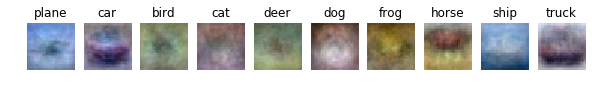

In [18]:
# 可视化best_W
w = best_softmax.W[:,:-1]
w = w.reshape((w.shape[0], 32, 32, 3))
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for y, cls in enumerate(classes):
    plt.subplot(1, 10, y+1)
    wimg = 255.0 * ((w[y] - w_min) / (w_max - w_min))
    plt.imshow(wimg.astype(np.uint8))
    plt.axis('off')
    plt.title(cls)
plt.show()